In [ ]:
In this experiment, deep neural network DNN, long and short-term memory network LSTM and differential integrated moving average autoregressive ARIMA model are implemented to predict A-shares


## runtime environment


In [ ]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import paddle
import paddle.fluid as fluid
import paddle.fluid.layers as layers

import statsmodels.api as sm 
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima_model import ARIMA
import math

### GPU(CPU)

In [ ]:
# place = fluid.CUDAPlace(0) 
place = fluid.CPUPlace() 

## data cleaning

### import data

In [ ]:
data_pd = pd.read_csv('./data/data72449/shangzheng.csv')

### View data header

In [ ]:
data_pd.head()
# data_pd.tail()
# data_pd.describe()
# data_pd.info()

,date,over,begin,high,low,trade,wave
0,2000年1月4日,1406.37,1368.69,1407.52,1361.21,437.09M,2.91%
1,2000年1月5日,1409.68,1407.83,1433.78,1398.32,688.09M,0.24%
2,2000年1月6日,1463.94,1406.04,1463.95,1400.25,809.05M,3.85%
3,2000年1月7日,1516.60,1477.15,1522.83,1477.15,1.60B,3.60%
4,2000年1月10日,1545.11,1531.71,1546.72,1506.40,1.51B,1.88%


### Abnormal item cleaning

In [ ]:
data_pd.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5130 entries, 0 to 5129
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    5130 non-null   object 
 1   over    5130 non-null   float64
 2   begin   5130 non-null   float64
 3   high    5130 non-null   float64
 4   low     5130 non-null   float64
 5   trade   5130 non-null   object 
 6   wave    5130 non-null   object 
dtypes: float64(4), object(3)
memory usage: 280.7+ KB


### Draw pictures to view the data

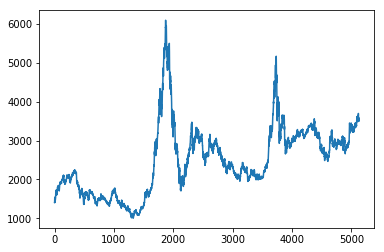

In [ ]:
plt.plot(data_pd['over'])

### Extraction requires data and formatting

In [ ]:
data_pd.set_index('date', inplace=True)
data_pd.drop(columns=['trade', 'wave'], inplace=True)
data_pd.head()

,over,begin,high,low
date,,,,
2000年1月4日,1406.37,1368.69,1407.52,1361.21
2000年1月5日,1409.68,1407.83,1433.78,1398.32
2000年1月6日,1463.94,1406.04,1463.95,1400.25
2000年1月7日,1516.60,1477.15,1522.83,1477.15
2000年1月10日,1545.11,1531.71,1546.72,1506.40


### standardized data

In [ ]:
split_boundary = int(data_pd.shape[0] * 0.8)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_pd[:split_boundary])
data_transform = scaler.transform(data_pd)

# data_transform

### Set up a time slide window, we use the data of the first 5 days to predict the data of the next day

In [ ]:
sequence_length = 5
delay = 1
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=sequence_length+delay):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

data = create_sequences(data_transform)
print("Training input shape: ", data.shape)

Training input shape:  (5124, 6, 4)


### Divide the training set and test set



In [ ]:
train = data[: split_boundary]
test = data[split_boundary:]

train.shape,test.shape

((4104, 6, 4), (1020, 6, 4))

### batch

In [ ]:
def switch_reader(is_val: bool = False):
    def reader():
      
        if is_val:

            for te in test:
                yield te[:sequence_length],te[-1:][:,0]
        else:

            for tr in train:
                yield tr[:sequence_length],tr[-1:][:,0]
        
    return reader   

#### batch

In [ ]:
batch_size = 128
train_reader = fluid.io.batch(reader=switch_reader(), batch_size=batch_size)
val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=batch_size)
for data in train_reader():
    # print(data[0].shape,data[1].shape)
    train_x=np.array([x[0] for x in data],np.float32)
    train_y = np.array([x[1] for x in data]).astype('int64')
    print(train_x.shape,train_y.shape)

(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(8, 5, 4) (8, 1)


## DNN

### define DNN

In [ ]:
class MyDNNModel(fluid.dygraph.Layer):
    '''
    DNN网络
    '''
    def __init__(self):
        super(MyDNNModel,self).__init__()
        self.fc1=fluid.dygraph.Linear(5*4,10,act='relu')
        self.fc2=fluid.dygraph.Linear(10,1)
        
    def forward(self,input):        
        '''前向计算'''
       
        input =fluid.layers.reshape(input,shape=[-1,5*4])
        out=self.fc1(input)
        out=self.fc2(out)
        # print(out.shape)
        return out

### Loss plotting function



In [ ]:
def draw_train_loss(Batchs, train_loss,eval_loss, label=""):
    # print(len(Batchs), len(train_loss), len(eval_loss))
    plt.figure(figsize=(10, 6))
    title= label + " training-eval loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.plot(Batchs, eval_loss, color='g', label='eval loss')
    plt.legend()
    plt.grid()
    plt.savefig('./img/'+ label + '_loss.png', dpi=300)
    plt.show()

    # print(Batchs, train_loss)

### training 

epoch:0,batch_id:10,train_loss:[0.01952308],eval_loss:0.01870791179438432
epoch:1,batch_id:10,train_loss:[0.01750821],eval_loss:0.01677239468942086
epoch:2,batch_id:10,train_loss:[0.01564891],eval_loss:0.014983377885073423
epoch:3,batch_id:10,train_loss:[0.0139363],eval_loss:0.013334243403126797
epoch:4,batch_id:10,train_loss:[0.0123716],eval_loss:0.011824272417773804
epoch:5,batch_id:10,train_loss:[0.01095283],eval_loss:0.01045409201954802
epoch:6,batch_id:10,train_loss:[0.00967765],eval_loss:0.009221728891134262
epoch:7,batch_id:10,train_loss:[0.00854252],eval_loss:0.008123515096182624
epoch:8,batch_id:10,train_loss:[0.00753426],eval_loss:0.007150782970711589
epoch:9,batch_id:10,train_loss:[0.00664602],eval_loss:0.006299050835271676
epoch:10,batch_id:10,train_loss:[0.00587446],eval_loss:0.005559576054414113
epoch:11,batch_id:10,train_loss:[0.00520018],eval_loss:0.004915598081424832
epoch:12,batch_id:10,train_loss:[0.00460567],eval_loss:0.004347955225966871
epoch:13,batch_id:10,train_

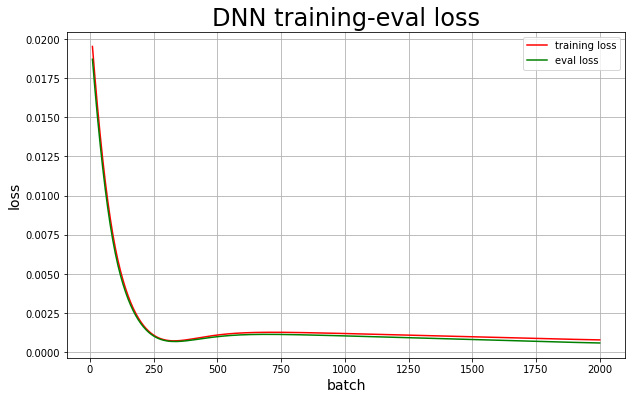

In [ ]:
with fluid.dygraph.guard(place):
    model=MyDNNModel() 
    model.train() 
    # opt=fluid.optimizer.SGDOptimizer(learning_rate=train_parameters['learning_strategy']['lr'], parameter_list=model.parameters())
    opt=fluid.optimizer.AdamOptimizer(learning_rate=0.0001, parameter_list=model.parameters()) 
    epochs_num=200
    batch_size = 128 * 3
    train_reader = fluid.io.batch(reader=switch_reader(), batch_size=batch_size)
    val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=batch_size)
    Batch=0
    Batchs=[]
    all_train_loss=[]
    all_eval_loss=[]
    for pass_num in range(epochs_num):
        for batch_id, data in enumerate(train_reader()): 
            data_x=np.array([x[0] for x in data],np.float32)
            data_y = np.array([x[1] for x in data]).astype('float32')
            data_x = fluid.dygraph.to_variable(data_x)
            data_y = fluid.dygraph.to_variable(data_y)
        
            # print(data_x.shape, data_y.shape)

            predict=model(data_x)
            # print(predict.shape)
            loss=fluid.layers.mse_loss(predict,data_y)
            avg_loss=fluid.layers.mean(loss)
            avg_loss.backward()       
            opt.minimize(avg_loss)   
            model.clear_gradients()  
            if batch_id!=0 and batch_id%10==0:
                Batch = Batch+10
                Batchs.append(Batch)
                all_train_loss.append(avg_loss.numpy()[0])
                evalavg_loss=[]
                for eval_data in val_reader():
                    eval_data_x = np.array([x[0] for x in eval_data],np.float32)
                    eval_data_y = np.array([x[1] for x in eval_data]).astype('float32')

                    eval_data_x = fluid.dygraph.to_variable(eval_data_x)
                    eval_data_y = fluid.dygraph.to_variable(eval_data_y)

                    eval_predict=model(eval_data_x)
                    eval_loss=fluid.layers.mse_loss(eval_predict,eval_data_y)
                    eval_loss=fluid.layers.mean(eval_loss)
                    evalavg_loss.append(eval_loss.numpy()[0])
                all_eval_loss.append(sum(evalavg_loss)/len(evalavg_loss))
        print("epoch:{},batch_id:{},train_loss:{},eval_loss:{}".format(pass_num,batch_id,avg_loss.numpy(),sum(evalavg_loss)/len(evalavg_loss)))     

    fluid.save_dygraph(model.state_dict(),'./model/MyDNNModel')
    fluid.save_dygraph(opt.state_dict(),'./model/MyDNNModel')
    print("Final loss: {}".format(avg_loss.numpy()))    

draw_train_loss(Batchs,all_train_loss,all_eval_loss, 'DNN')

## LSTM

### define LSTM


In [ ]:
import paddle.fluid as fluid
class MyLSTMModel(fluid.dygraph.Layer):
 
    def __init__(self):
        super(MyLSTMModel,self).__init__()
        self.rnn = paddle.nn.LSTM(4, 20, 2)
        self.flatten = paddle.nn.Flatten()
        self.fc1=fluid.dygraph.Linear(5*20,10)
        self.fc2=fluid.dygraph.Linear(10,1)

        
    def forward(self,input):        
        
        # print('input',input.shape)
        out, (h, c)=self.rnn(input)
        out =self.flatten(out)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

### training 

epoch:0,batch_id:10,train_loss:[0.01361275],eval_loss:0.02257246244698763
epoch:1,batch_id:10,train_loss:[0.07703531],eval_loss:0.05712037657697996
epoch:2,batch_id:10,train_loss:[0.01176795],eval_loss:0.02054892232020696
epoch:3,batch_id:10,train_loss:[0.00269285],eval_loss:0.0015266626918067534
epoch:4,batch_id:10,train_loss:[0.00181504],eval_loss:0.0017056632398938139
epoch:5,batch_id:10,train_loss:[0.0031247],eval_loss:0.001436287226776282
epoch:6,batch_id:10,train_loss:[0.00093001],eval_loss:0.0006579701439477503
epoch:7,batch_id:10,train_loss:[0.00105162],eval_loss:0.0013829594245180488
epoch:8,batch_id:10,train_loss:[0.00452445],eval_loss:0.006132860668003559
epoch:9,batch_id:10,train_loss:[0.00180459],eval_loss:0.00112524488940835
epoch:10,batch_id:10,train_loss:[0.00086761],eval_loss:0.0012881977211994429
epoch:11,batch_id:10,train_loss:[0.00082518],eval_loss:0.0006624077310940871
epoch:12,batch_id:10,train_loss:[0.00091848],eval_loss:0.0009353027562610805
epoch:13,batch_id:10

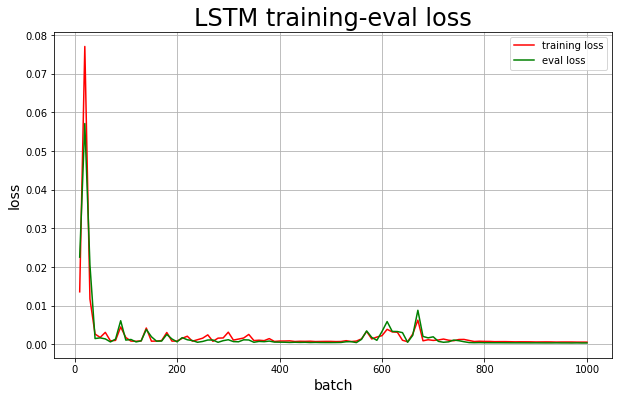

In [ ]:
with fluid.dygraph.guard(place):
    model=MyLSTMModel() 
    # model=MyModel()
    model.train() 
    # opt=fluid.optimizer.SGDOptimizer(learning_rate=0.001, parameter_list=model.parameters())
    opt=fluid.optimizer.AdamOptimizer(learning_rate=0.01, parameter_list=model.parameters()) 
    epochs_num=100
    batch_size = 128*3
    train_reader = fluid.io.batch(reader=switch_reader(), batch_size=batch_size)
    val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=batch_size)
    Batch=0
    Batchs=[]
    all_train_loss=[]
    all_eval_loss=[]
    for pass_num in range(epochs_num):
        for batch_id, data in enumerate(train_reader()): 
            data_x=np.array([x[0] for x in data],np.float32)
            data_y = np.array([x[1] for x in data]).astype('float32')
            data_x = fluid.dygraph.to_variable(data_x)
            data_y = fluid.dygraph.to_variable(data_y)
        
            # print(data_x.shape, data_y.shape)

            predict=model(data_x)
            # print(predict.shape)
            loss=fluid.layers.mse_loss(predict,data_y)
            avg_loss=fluid.layers.mean(loss)
            avg_loss.backward()       
            opt.minimize(avg_loss)    
            model.clear_gradients()   
            if batch_id!=0 and batch_id%10==0:
                Batch = Batch+10
                Batchs.append(Batch)
                all_train_loss.append(avg_loss.numpy()[0])
                evalavg_loss=[]
                for eval_data in val_reader():
                    eval_data_x = np.array([x[0] for x in eval_data],np.float32)
                    eval_data_y = np.array([x[1] for x in eval_data]).astype('float32')

                    eval_data_x = fluid.dygraph.to_variable(eval_data_x)
                    eval_data_y = fluid.dygraph.to_variable(eval_data_y)

                    eval_predict=model(eval_data_x)
                    eval_loss=fluid.layers.mse_loss(eval_predict,eval_data_y)
                    eval_loss=fluid.layers.mean(eval_loss)
                    evalavg_loss.append(eval_loss.numpy()[0])
                all_eval_loss.append(sum(evalavg_loss)/len(evalavg_loss))
        print("epoch:{},batch_id:{},train_loss:{},eval_loss:{}".format(pass_num,batch_id,avg_loss.numpy(),sum(evalavg_loss)/len(evalavg_loss)))     

    fluid.save_dygraph(model.state_dict(),'./model/MyLSTMModel')
    fluid.save_dygraph(opt.state_dict(),'./model/MyLSTMModel')
    print("Final loss: {}".format(avg_loss.numpy()))    
   
draw_train_loss(Batchs,all_train_loss,all_eval_loss, 'LSTM')

## ARIMA

###As can be seen from the data graph, this data is not stationary data. So I'm going to do it in a logarithmic way.

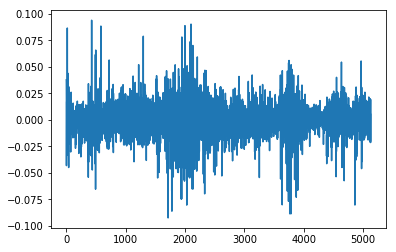

In [ ]:
data_arma = np.log(data_pd['over'].values)

data_arma_diff = np.diff(data_arma)[1:]

plt.plot(data_arma_diff)

### We run the ADF test and we're 99% sure that we reject the null hypothesis, that the sequence is stable



In [ ]:

print('ADF：',sm.tsa.stattools.adfuller(data_arma_diff))

数据ADF检验： (-16.832939284099503, 1.1541145534317975e-29, 14, 5113, {'1%': -3.4316295982872163, '5%': -2.862105446825125, '10%': -2.5670709875579742}, -28114.78953050096)


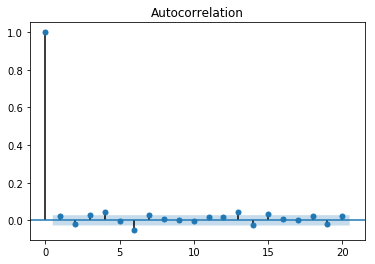

In [ ]:

fig = sm.graphics.tsa.plot_acf(data_arma_diff,lags=20)

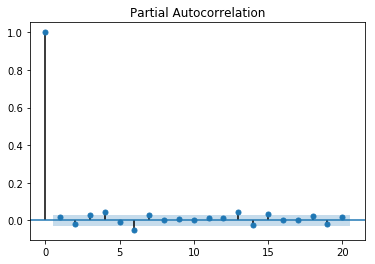

In [ ]:

fig = sm.graphics.tsa.plot_pacf(data_arma_diff,lags=20)

In [ ]:

arima_mod10 = sm.tsa.arima.ARIMA(data_arma,order=(1,1,0)).fit()
print(arima_mod10.aic,arima_mod10.bic,arima_mod10.hqic)

# ARIMA（2,1,0）
arima_mod20 = sm.tsa.arima.ARIMA(data_arma,order=(2,1,0)).fit()
print(arima_mod20.aic,arima_mod20.bic,arima_mod20.hqic)

# ARIMA（2,1,2）
arima_mod22 = sm.tsa.arima.ARIMA(data_arma,order=(2,1,2)).fit()
print(arima_mod22.aic,arima_mod22.bic,arima_mod22.hqic)

# ARIMA（2,1,1）
arima_mod21 = sm.tsa.arima.ARIMA(data_arma,order=(2,1,1)).fit()
print(arima_mod21.aic,arima_mod21.bic,arima_mod21.hqic)

-28216.94080446194 -28203.85547248716 -28212.36051191957
-28216.65350553987 -28197.025507577702 -28209.783066726315
-28220.09157165933 -28187.378241722385 -28208.6408403034


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


-28214.711599602502 -28188.540935652945 -28205.55101451776


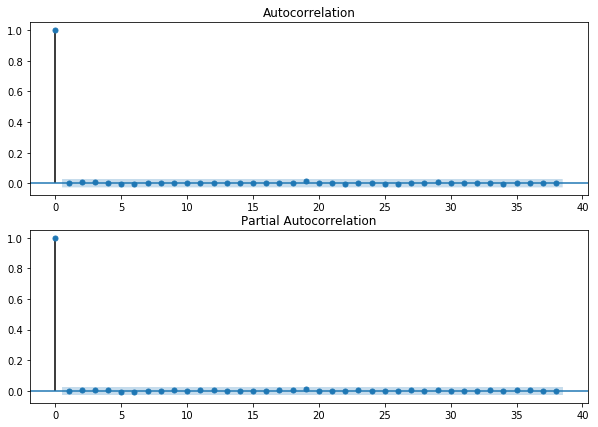

In [ ]:

arima_mod=arima_mod10
resid = arima_mod.resid
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid,ax=ax2)

In [ ]:
print(sm.stats.durbin_watson(arima_mod.resid))

1.0221139759680866


##  The Result of Previous Training

### predict the outcome

#### Data set reduction function

> The data normalized at the beginning needs to be restored during the actual drawing



In [ ]:
def inverse_transform(arr):
    zero_arr = np.zeros((arr.shape[0], 3))
    zero_data = np.hstack((arr, zero_arr))
    # print(zero_data)
    zero_data = scaler.inverse_transform(zero_data)
    # print(zero_data)
    
    return zero_data[:, 0]


#### Training set data prediction results



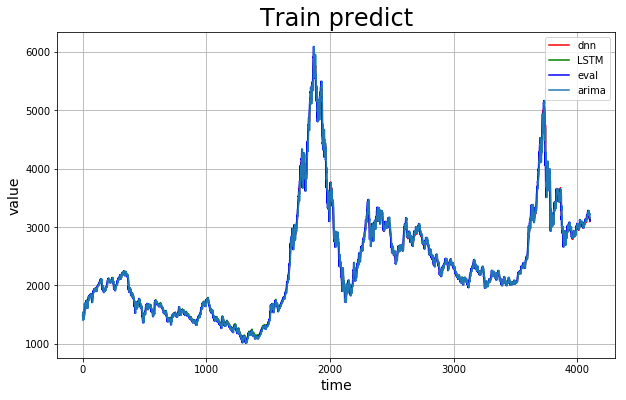

In [ ]:
with fluid.dygraph.guard(place):
    accs = []
    dnn_predict = []
    model_lstm_dict, _ = fluid.load_dygraph('./model/MyLSTMModel.pdopt')
    model_dnn_dict, _ = fluid.load_dygraph('./model/MyDNNModel.pdopt')
    model_lstm = MyLSTMModel()
    model_dnn = MyDNNModel()
    model_lstm.load_dict(model_lstm_dict)
    model_dnn.load_dict(model_dnn_dict) 

    train_reader = fluid.io.batch(reader=switch_reader(is_val=False), batch_size=train.shape[0])
    train_data_x = np.array([x[0] for x in next(train_reader())],np.float32)
    train_data_y = np.array([x[1] for x in next(train_reader())]).astype('float32')

    train_data_x = fluid.dygraph.to_variable(train_data_x)
    train_data_y = fluid.dygraph.to_variable(train_data_y)

    train_dnn=model_dnn(train_data_x)
    train_lstm=model_lstm(train_data_x)

train_arma = arima_mod.predict(1, train.shape[0])
train_arma = math.e**(train_arma)

plt.figure(figsize=(10, 6))
title="Train predict"
plt.title(title, fontsize=24)
plt.xlabel("time", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.plot(range(train.shape[0]), inverse_transform(train_dnn.numpy()), color='red', label='dnn')
plt.plot(range(train.shape[0]), inverse_transform(train_lstm.numpy()), color='g', label='LSTM')
plt.plot(range(train.shape[0]), inverse_transform(train_data_y.numpy()), color='b', label='eval')
plt.plot(range(train.shape[0]), train_arma, label='arima')
plt.legend()
plt.grid()
plt.savefig('./img/train_res.png', dpi=300)
plt.show()

#### Verification sets predict results



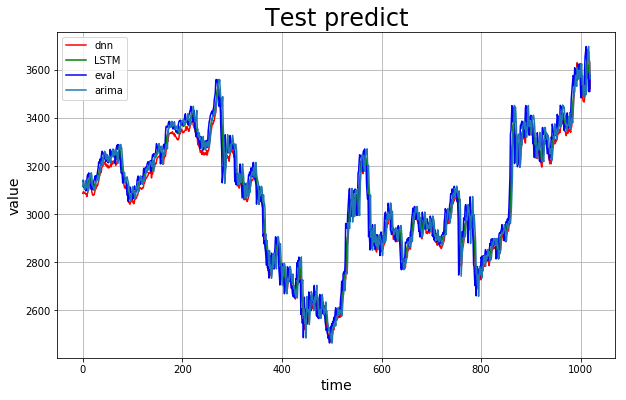

In [ ]:
with fluid.dygraph.guard(place):
    accs = []
    dnn_predict = []
    model_lstm_dict, _ = fluid.load_dygraph('./model/MyLSTMModel.pdopt')
    model_dnn_dict, _ = fluid.load_dygraph('./model/MyDNNModel.pdopt')
    model_lstm = MyLSTMModel()
    model_dnn = MyDNNModel()
    model_lstm.load_dict(model_lstm_dict)
    model_dnn.load_dict(model_dnn_dict) 

    val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=test.shape[0])
    # print(len(next(val_reader())))
    eval_data_x = np.array([x[0] for x in next(val_reader())],np.float32)
    eval_data_y = np.array([x[1] for x in next(val_reader())]).astype('float32')

    eval_data_x = fluid.dygraph.to_variable(eval_data_x)
    eval_data_y = fluid.dygraph.to_variable(eval_data_y)

    eval_dnn=model_dnn(eval_data_x)
    eval_lstm=model_lstm(eval_data_x)

test_arma = arima_mod.predict(train.shape[0]+1, train.shape[0]+test.shape[0])
test_arma = math.e**(test_arma)

plt.figure(figsize=(10, 6))
title="Test predict"
plt.title(title, fontsize=24)
plt.xlabel("time", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.plot(range(test.shape[0]), inverse_transform(eval_dnn.numpy()), color='red', label='dnn')
plt.plot(range(test.shape[0]), inverse_transform(eval_lstm.numpy()), color='g', label='LSTM')
plt.plot(range(test.shape[0]), inverse_transform(eval_data_y.numpy()), color='b', label='eval')
plt.plot(range(test.shape[0]), test_arma, label='arima')
plt.legend()
plt.grid()
plt.savefig('./img/test_res.png', dpi=300)
plt.show()
